# todo
I want to study how the latent space representation of s and the alpha carbon backbone (and z at some point, but z is thicc) changes in the structure module

Phase 1
- save representations (see algorithm 20 for structure module)
  - s (line 9), X_ca (line 16)
  - s_i (line 1), z_i (line 2)
- run cameo dataset
- now i have latent space reps at each iteration 8 * 4 recycles = 32
- flatten this space and use similarity metric such as cosine similarity metric
- plot (similar to what Julia did) a grid 32 by 32 that shows similarity between each latent space representation at each iteration and recycle

Phase 2
- With s_i (line 1) and z_i (line 2) I can run the structure module by itself
  - This saves a ton of compute time as I run purterbation tests on the struct modu
- do DOE purterbations

**phone notes from meeting**
Algorithm 20 line 1 and 2 save those at each recycle and compare them. Nontrivial: want to set things up so I can run struc module with these loaded files. So once I have the s and z rep I can just input those into the struct module and just run that. Talk to charlotte about that. Save 1 2 and then save after line 9 at ever iteration of the for loop. Latent space tracking is 9 then to track the structure I would save line 16. 16 (alpha carbon backbone) is better than pdb to look at inside the forloop. Check out cosine similarity to compare the representations over time. Maybe Julia has an idea for comparisons as well… initial run where you do these saves do no purturbation. This is valuable to see how it evolves no purterbation. This is first step. Purturbation step. Take 1 and 2 and inject into struct module. Zero si after 9 then save struc (line 16) puterb just first iteration and save at each iteration line 9 and 16. Next run, just perturb at 2nd iteration only but still save everywhere.

So in the end I’ll have data for 8 iterations * 8 purturbation spots * 4 recycles. 

Goal by this Friday: do this run, flatten vector for each iteration and compare. (See photos) in this plot it will be 32x32 to see sequence similarity between flattened tensors. 32= 8iteration*4 recycle.

Also maybe do some caparisons for the plots I’ve already generated vs ground truth. So tmscore(purterbed,ground truth)


Puturbation list
  - s=0 at
    - before structure module
    - first iteration of structure module
    - at each iteration?
    - after structure module runs and is about to recycle?
  - do this for regular, 3 recycling (is this corret?), runs and for one 1 recylcing run
  - **track latent space rep (julia recommended) as it progresses through structure module
  - **track predicted shape as it evolves inside the structure module (track through alpha carbon backbone X_ca that i saved)

- finish compiling (and double checking) all multiple conformations present in AF training data. Make an batch download script for it...




In [203]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt


In [204]:
LATENTSPACE_UNPERTURBED = "../data/taccruns/predictions/"#"../data/taccruns/predictions-latentspace-unperturbed/"

In [233]:
#lst_iterations = [f"r{r}i{i}" for r in range(4) for i in range(8)]
lst_iterations = [f"i{i}" for r in range(4) for i in range(8)]
lst_iterations[0] = "r0 i0"
lst_iterations[8] = "r1 i0"
lst_iterations[16] = "r2 i0"
lst_iterations[24] = "r3 i0"
#lst_iterations = ['evo'] + lst_iterations

cos = nn.CosineSimilarity(dim=0)
def latent_space_cosine_grid(protein, rep):
    data = np.empty([32,32]) 
    for r1 in range(4):
        for i1 in range(8):
            for r2 in range(4):
                for i2 in range(8):
                    file_1 = LATENTSPACE_UNPERTURBED + protein + '_lspace' + '/' + rep + '_iter_' + str(i1) + '_recy_' + str(r1) + '_.pt'
                    file_2 = LATENTSPACE_UNPERTURBED + protein + '_lspace' + '/' + rep + '_iter_' + str(i2) + '_recy_' + str(r2) + '_.pt'
                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*8)+i1, (r2*8)+i2] = cos(t1,t2)
    return data


In [235]:
protein = '7tav_B'
rep = 's'
i = 0
r = 0
file = LATENTSPACE_UNPERTURBED + protein + '_lspace' + '/' + rep + '_iter_' + str(i) + '_recy_' + str(r) + '_.pt'
t = torch.flatten(torch.load(file, map_location=torch.device('cpu')))
print('r',r,'i',i,t)
rep = 's'
i = 1
r = 0
file = LATENTSPACE_UNPERTURBED + protein + '_lspace' + '/' + rep + '_iter_' + str(i) + '_recy_' + str(r) + '_.pt'
t = torch.flatten(torch.load(file, map_location=torch.device('cpu')))
print('r',r,'i',i,t)

r 0 i 0 tensor([-0.3024, -0.0890, -0.6227,  ...,  0.0804,  0.0517,  0.1375])
r 0 i 1 tensor([ 0.0289, -0.0939, -0.0019,  ...,  0.0984,  0.0164,  0.0221])


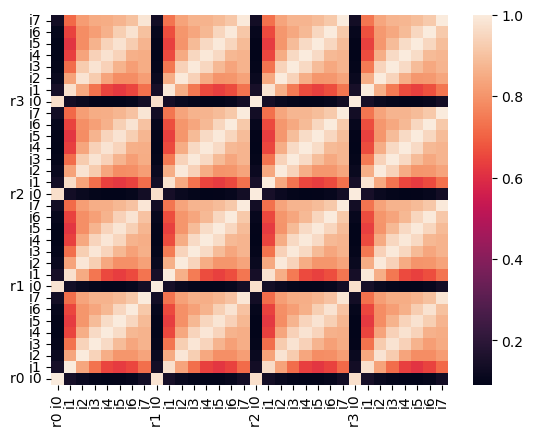

In [240]:
ax = sns.heatmap(latent_space_cosine_grid('7tav_B','s'), xticklabels = lst_iterations, yticklabels = lst_iterations, annot=False)
ax.invert_yaxis()

In [210]:
list_proteins = []
for file in os.listdir(LATENTSPACE_UNPERTURBED):
    if file[-1] == 'b':
        list_proteins.append(file[0:6])
        

7tav_B


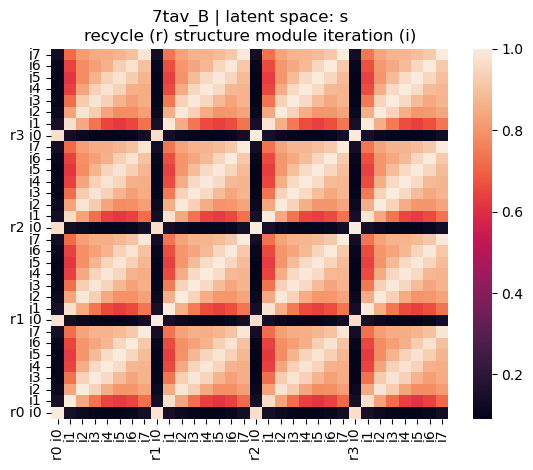

7eea_A


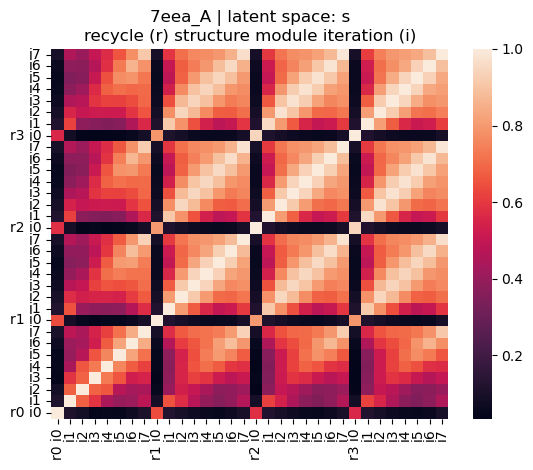

7bny_B


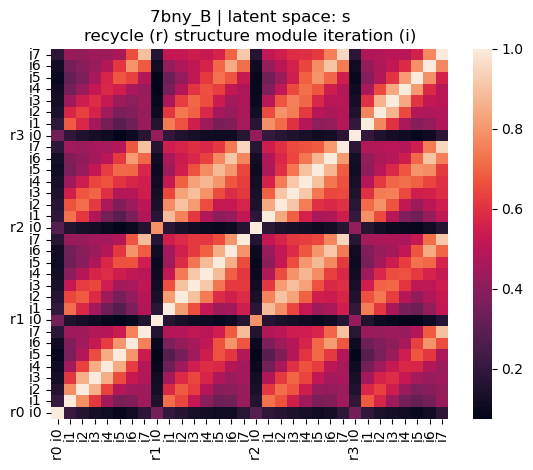

In [245]:
l = 's'
particularly_red = ['7tav_B','7eea_A','7bny_B']
for protein in particularly_red: #list_proteins:
    print(protein)
    ax = sns.heatmap(latent_space_cosine_grid(protein, l), xticklabels = lst_iterations, yticklabels = lst_iterations, annot=False)
    ax.invert_yaxis()
    ax.set_title(protein + f' | latent space: {l}\n' + 'recycle (r) structure module iteration (i)' )
    plt.show()

In [ ]:
# old code that didn't work. maybe useful for reference later

lst_iterations = [f"r{r}i{i}" for r in range(4) for i in range(8)]
lst_results = [np.ones(4)*i for i in range(32)]
df = pd.DataFrame({'a': lst_iterations,
                   'a_results': lst_results,
                   'b': lst_iterations,
                   'b_results': lst_results
                  })
df_pivot = df.pivot_table(values=['a_results', 'b_results'], index='a',columns='b',aggfunc=np.sum)
###
df = pd.DataFrame(columns=lst_iterations)#, index=lst_iterations)
for r in range(4):
    for i in range(8):
        df.loc[f"r{r}i{i}",f"r{r}i{i}"] = float(i+r)
df